## Importing the required libraries

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import geopandas as gpd


## Data Filtering:

### Importing the data

In [106]:
gdf = gpd.read_file('karnataka.geojson')
karnataka_border = gdf.dissolve()

In [107]:
df = pd.read_csv("clustering_data.csv", low_memory=False, dtype=object)

#This filters out my home state "Karnataka"
Filtered_df = df[df['StateName'] == 'KARNATAKA']

#This removes all the data where either of latitude or longitude is not provided.
Filtered_df = Filtered_df[Filtered_df['Latitude'].notna()]
Filtered_df = Filtered_df[Filtered_df['Longitude'].notna()]
Filtered_df['Latitude'] = Filtered_df['Latitude'].astype(str).str.replace('-', '', regex=False)
Filtered_df['Longitude'] = Filtered_df['Longitude'].astype(str).str.replace('-', '', regex=False)

Filtered_df['Latitude'] = Filtered_df['Latitude'].astype(float)
Filtered_df['Longitude'] = Filtered_df['Longitude'].astype(float)
#Some points have been mislabelled as Karnataka. Using a simple algorithm to exclude them
minLat = 11.55
maxLat = 18.6
minLong = 74.0
maxLong = 78.7
Filtered_df = Filtered_df[(Filtered_df['Latitude']<maxLat) & (Filtered_df['Latitude']>minLat) & (Filtered_df['Longitude']<maxLong) & (Filtered_df['Longitude']>minLong)]

X = [Filtered_df['Latitude'],Filtered_df['Longitude']]
X = np.array(X)

## Data Visualization:

NOTE: I have used library geopandas to plot the state border or karnataka for better visualisation

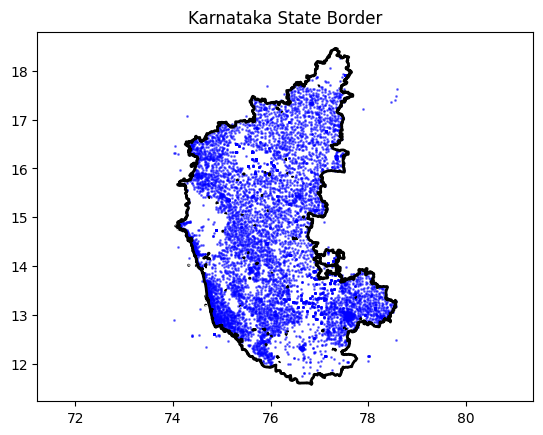

In [108]:
karnataka_border.plot(edgecolor='black', facecolor='none', linewidth=2, zorder =2)
plt.title('Karnataka State Border')
plt.axis('equal')
plt.scatter(Filtered_df['Longitude'], Filtered_df['Latitude'], color='blue', s=1, alpha=0.5, zorder = 1)
#zorder helps to decide overlay the border over the points
plt.show()


## K-means clustering

In [109]:
class KmeansClustering:

    def __init__(self, k=3):
        self.k = k
        #Initialising centroids to none
        self.centroids = None

    @staticmethod
    #Euclidean Distance Calculation
    def eucDist(a,b):
        return np.sqrt(np.sum((a-b)**2, axis = 1))

    def fit(self , X, max_iterations = 500):
        # This is basically choosing a random value between the minimum and maximum of each dimension
        self.centroids = np.random.uniform(np.amin(X, axis =0), np.amax(X, axis = 0),size = (self.k, X.shape[1]))

        # Now we assign each point to a cluster

        for _ in range(max_iterations):
            # y is basically an array which stores the cluster that each point belongs to
            y = []

            for point in X:
                distances = KmeansClustering.eucDist(point, self.centroids)

                # Now we find the centroid closest to each point and assign that centroid to that point
                cluster_number = np.argmin(distances)
                y.append(cluster_number)

            y = np.array(y)

            # This array is basically the opposite of the previous array. It stores all the points belonging to a cluster
            cluster_index = []

            for i in range(self.k):
                cluster_index.append(np.where(y==i))

            cluster_centers = []

            for i, indices in enumerate(cluster_index):
                if len(indices) == 0:
                    cluster_centers.append(self.centroids[i])
                #Choosing new centroid points to be mean of the current cluster points
                else:
                    cluster_centers.append(np.mean(X[indices], axis = 0))

            #Breaking if there isn't that much change in location
            if np.max(np.abs(self.centroids-np.array(cluster_centers))) < 0.0001:
                break
            else:
                self.centroids = np.array(cluster_centers)
        return y


## Plotting the K-means Algorithm

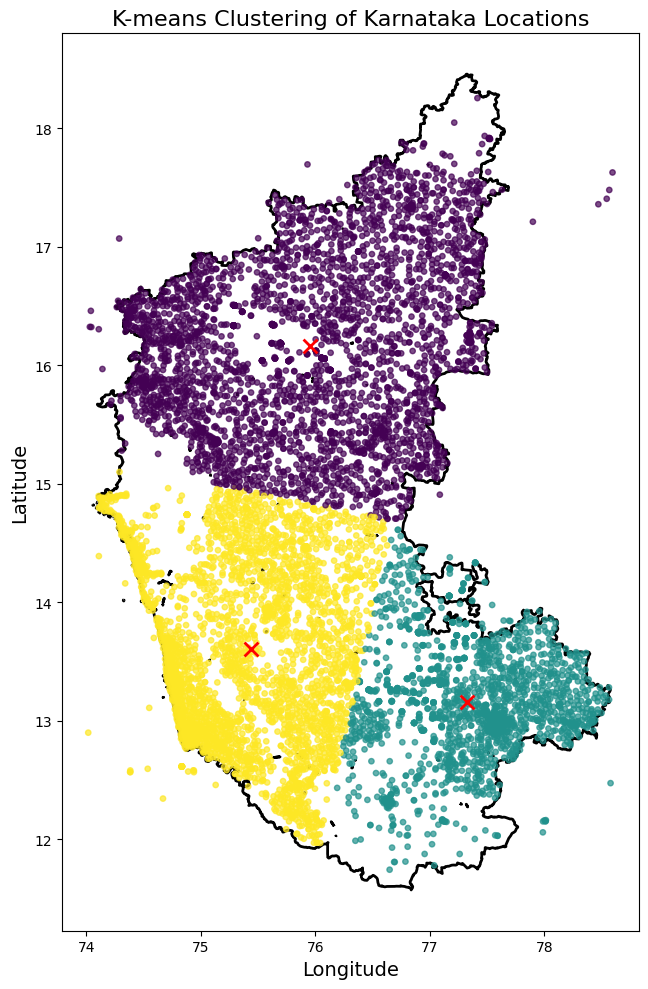

In [112]:
# After running your K-means clustering
kmeans = KmeansClustering(k=3)

X_for_clustering = np.array(Filtered_df[['Latitude', 'Longitude']])
labels = kmeans.fit(X_for_clustering)

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Karnataka border
karnataka_border.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2, zorder=1)

# Plot clustered points
scatter = ax.scatter(
    Filtered_df['Longitude'],
    Filtered_df['Latitude'],
    c=labels,
    cmap='viridis',
    s=15,
    alpha=0.7,
    zorder=2
)

# Plot centroids
centroids = kmeans.centroids
plt.scatter(
    centroids[:, 1],  # Longitude is second column in your centroids
    centroids[:, 0],  # Latitude is first column in your centroids
    s=100,
    marker='x',
    color='red',
    linewidths=2,
    zorder=3
)

# Add title and labels
plt.title('K-means Clustering of Karnataka Locations', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)


plt.tight_layout()
plt.show()




## Elbow Method

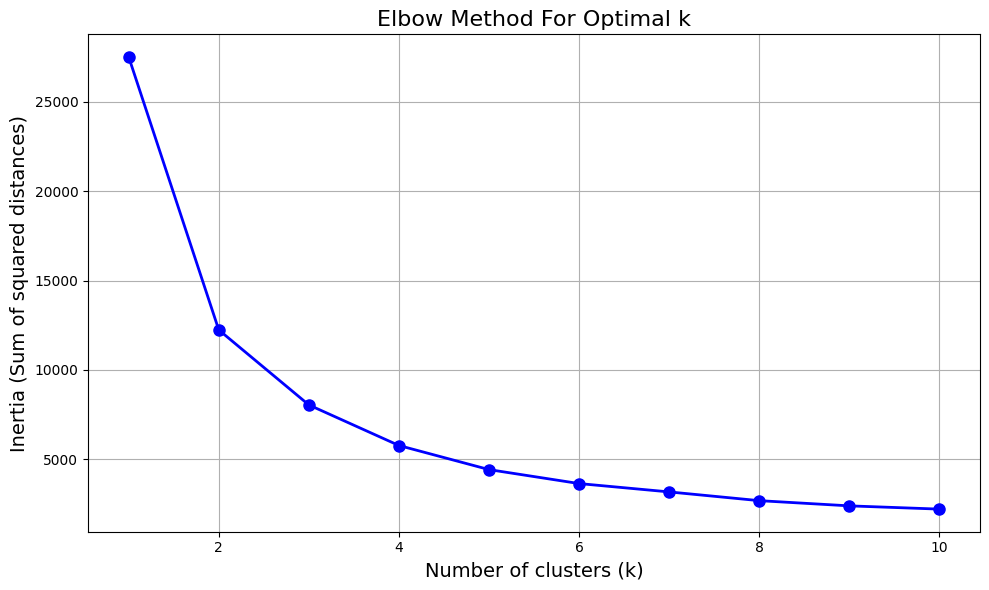

In [111]:
# Prepare data for clustering - ensure correct format
X_for_clustering = np.array(Filtered_df[['Latitude', 'Longitude']])

# Calculate inertia for different k values
inertia = []
k_values = range(1, 11)  # Test k from 1 to 10

for k in k_values:
    # Using sklearn's KMeans for reliable inertia calculation
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_for_clustering)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)', fontsize=14)
plt.ylabel('Inertia (Sum of squared distances)', fontsize=14)
plt.title('Elbow Method For Optimal k', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


Choosing k = 4 based on the above elbow graph:

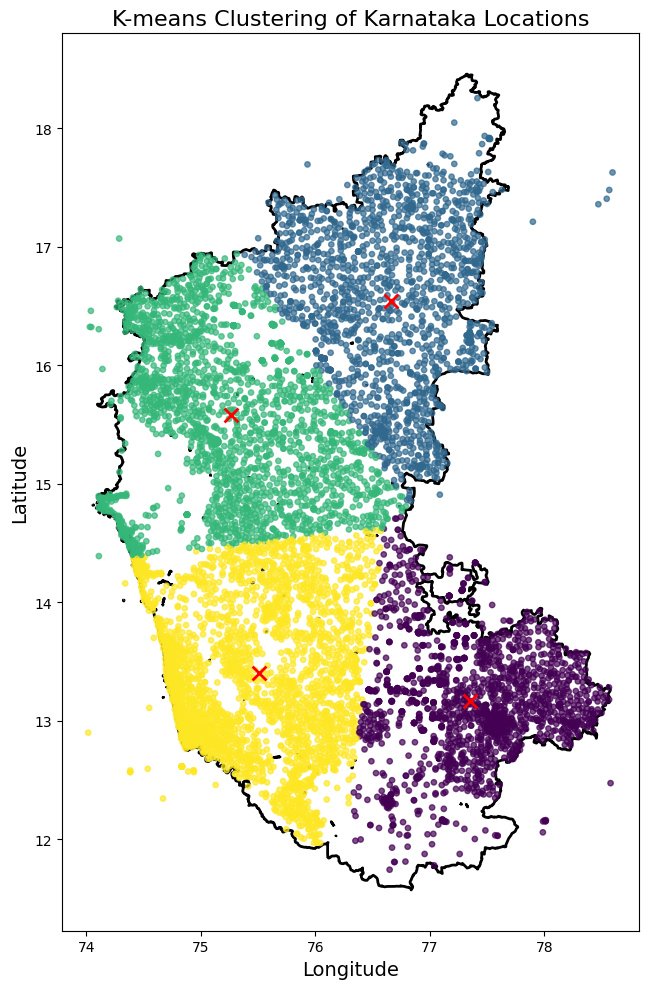

In [113]:
# After running your K-means clustering
kmeans = KmeansClustering(4)

X_for_clustering = np.array(Filtered_df[['Latitude', 'Longitude']])
labels = kmeans.fit(X_for_clustering)

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Karnataka border
karnataka_border.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2, zorder=1)

# Plot clustered points
scatter = ax.scatter(
    Filtered_df['Longitude'],
    Filtered_df['Latitude'],
    c=labels,
    cmap='viridis',
    s=15,
    alpha=0.7,
    zorder=2
)

# Plot centroids
centroids = kmeans.centroids
plt.scatter(
    centroids[:, 1],  # Longitude is second column in your centroids
    centroids[:, 0],  # Latitude is first column in your centroids
    s=100,
    marker='x',
    color='red',
    linewidths=2,
    zorder=3
)

# Add title and labels
plt.title('K-means Clustering of Karnataka Locations', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)


plt.tight_layout()
plt.show()


